In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Analysis with real life option data

The data are sourced from OptionMetrics Ivy DB US, accessed using Wharton Research Data Services.

In [2]:
# Load the CSV file
data_options_path = os.path.expanduser("~/Downloads/qkn5ldiosjukbckd.csv")
data_security_path = os.path.expanduser("~/Downloads/dkpteihlwrfnfwst.csv")

# Read the data
df_options = pd.read_csv(data_options_path, encoding='utf-8')
df_security = pd.read_csv(data_security_path, encoding='utf-8')

# Filter out tickers that are not suitable for Black-Scholes analysis
# Reasons for exclusion:
# - European-style options: SPX, DJX (indices)
# - Significant dividend payers: PG, JNJ, AAPL, F
# (European Black-Scholes doesn't account for dividends or American early exercise)
excluded_tickers = ['SPX', 'DJX', 'PG', 'JNJ', 'F', 'AAPL']

df_options = df_options[~df_options['ticker'].isin(excluded_tickers)]
df_security = df_security[~df_security['ticker'].isin(excluded_tickers)]

print(f"Data loaded successfully!")
print(f"Excluded tickers: {', '.join(excluded_tickers)}")
print(f"Options Data Shape: {df_options.shape[0]} rows × {df_options.shape[1]} columns")
print(f"Security Data Shape: {df_security.shape[0]} rows × {df_security.shape[1]} columns")

Data loaded successfully!
Excluded tickers: SPX, DJX, PG, JNJ, F, AAPL
Options Data Shape: 15766 rows × 38 columns
Security Data Shape: 1260 rows × 19 columns


/var/folders/z4/h6nt6cb92jl9jsxg6g7h076m0000gp/T/ipykernel_46950/1492834465.py:6: DtypeWarning: Columns (32,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df_options = pd.read_csv(data_options_path, encoding='utf-8')


In [3]:
# print(df_options.keys())
# print(df_security.keys())
print(df_security['secid'].unique(), df_options['secid'].unique())
# Are they the same? Any secid that are in one but not the other?
set_options_secid = set(df_options['secid'].unique())
set_security_secid = set(df_security['secid'].unique())
print("Options secid not in Security secid:", set_options_secid - set_security_secid)
print("Security secid not in Options secid:", set_security_secid - set_options_secid)

[101310 107525 108321 143439 154402] [101310 107525 108321 143439 154402]
Options secid not in Security secid: set()
Security secid not in Options secid: set()


In [4]:
df_security[df_security['ticker'] == 'SPX']

Empty DataFrame
Columns: [secid, date, cusip, ticker, sic, index_flag, exchange_d, class, issue_type, industry_group, low, high, open, close, volume, return, cfadj, shrout, cfret]
Index: []

In [5]:
pd.to_datetime(df_options[df_options['secid'] == 101310]['exdate'])

0      2022-09-02
1      2022-09-02
2      2022-09-02
3      2022-09-02
4      2022-09-02
          ...    
4005   2024-06-21
4006   2024-06-21
4007   2024-06-21
4008   2024-06-21
4009   2024-06-21
Name: exdate, Length: 4010, dtype: datetime64[ns]

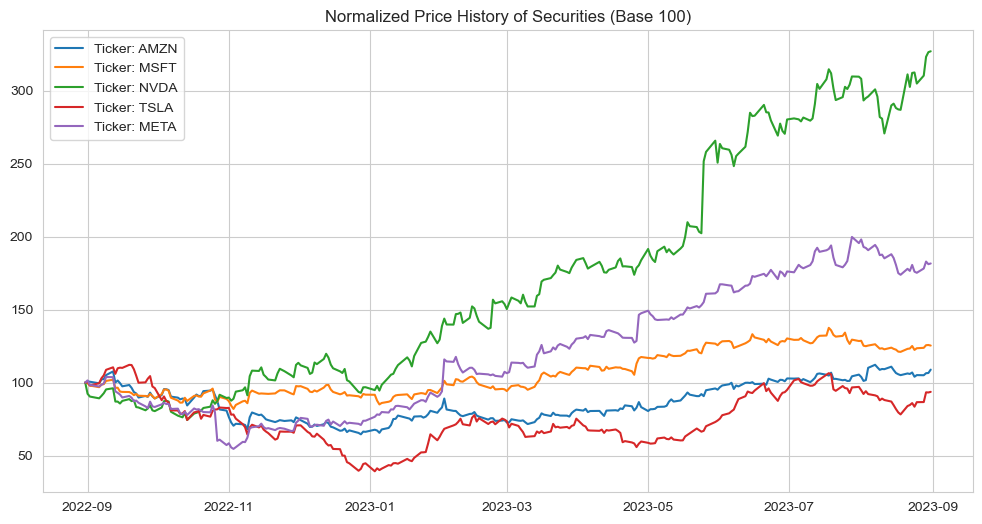

In [6]:
# Test: plot the price history of the securities
# for all security id, plot the close price history
for secid in df_security['secid'].unique():
    price_history = df_security[df_security['secid'] == secid]['close']
    normalized_price = (price_history / price_history.iloc[0]) * 100
    ticker = df_security[df_security['secid'] == secid]['ticker'].values[0]
    time = pd.to_datetime(df_security[df_security['secid'] == secid]['date'])
    plt.plot(time, normalized_price, label=f'Ticker: {ticker}')
plt.title("Normalized Price History of Securities (Base 100)")
plt.legend()
plt.show()

In [7]:
# Test: examine the call option prices
# The option price should yield some measures of implied volatility using Black-Scholes model

# Pick a security id
ticker = "AMZN"
#secid = 101310
df_options_secid = df_options[df_options['ticker'] == ticker]
secid = df_security[df_security['ticker'] == ticker]['secid'].values[0]
print(f"Analyzing options for secid: {secid}, ticker: {ticker}")

# The data fixes the starting date. Let's also fix expiration date
exdate = df_options_secid['exdate'].unique()[10]
print(f"Expiration date selected: {exdate}")
contract_length = (pd.to_datetime(exdate) - pd.to_datetime(df_options_secid['date'].min())).days
t = contract_length / 365  # Time to expiration in years

# We verify the risk-free interest rate using the zerocouponyieldcurve csv

data_rate = os.path.expanduser("~/Downloads/zerocouponyieldcurve.csv")
df_rate = pd.read_csv(data_rate, encoding='utf-8')
# Read the data for starting date 
starting_date = df_options['date'].unique()[0]
df_rate_start = df_rate[df_rate['date'] == starting_date].copy()

# Pick the entry closest to contract_length (without overwriting the original days column)
days_diff = np.abs(df_rate_start['days'] - contract_length)
closest_idx = days_diff.idxmin()
closest_rate_entry = df_rate_start.loc[closest_idx]
r = closest_rate_entry['rate'] / 100  # Convert percentage to decimal


print(f"Contract length: {contract_length} days")
print(f"Closest rate entry has date {closest_rate_entry['date']} and rate {closest_rate_entry['rate']:.4f}%")

Analyzing options for secid: 101310, ticker: AMZN
Expiration date selected: 2023-01-20
Contract length: 141 days
Closest rate entry has date 2022-09-01 and rate 3.0947%


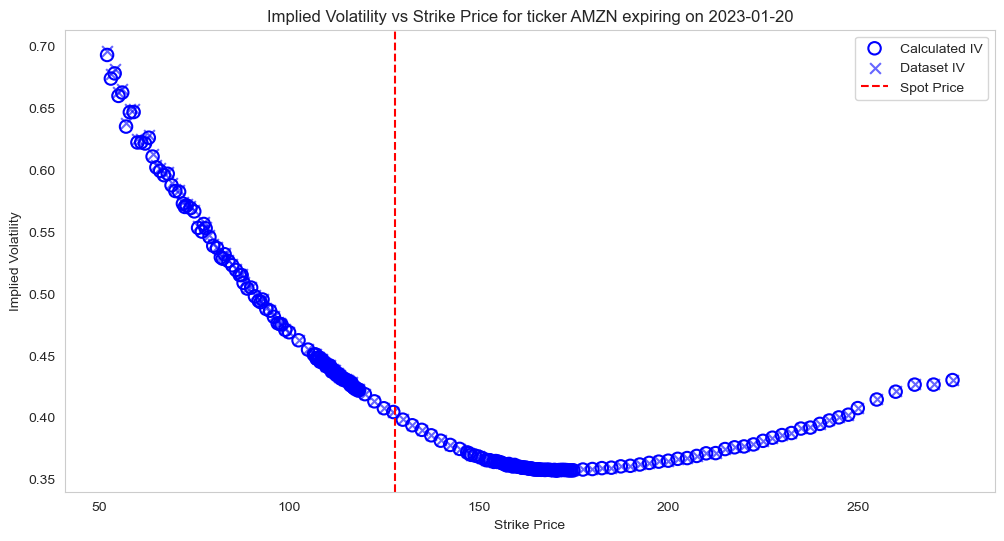

In [8]:
# Extract the data for the choosen contract length

spot_price = df_security[(df_security['secid'] == secid) & (df_security['date'] == starting_date)]['close'].values[0]

option_entries = df_options_secid[(df_options_secid['exdate'] == exdate) & (df_options_secid['date'] == starting_date)].copy()
option_entries['strike_price'] = option_entries['strike_price'] / 1000  # The strike prices are given in units of 1000 * actual strike price

# examine the call entries
call_entries = option_entries[option_entries['cp_flag'] == 'C'].copy()



# calculate the implied volatility for each call option entry
from src.black_scholes import implied_volatility_call
call_entries['implied_volatility_calculation'] = call_entries.apply(
    lambda row: implied_volatility_call(
        market_price=(row['best_bid'] + row['best_offer']) / 2,
        S0=spot_price,
        K=row['strike_price'],
        t=t,
        r=r)
    , axis=1
)

# Plot the implied volatility vs strike price
plt.scatter(call_entries['strike_price'], call_entries['implied_volatility_calculation'], 
            marker='o', s=80, facecolors='none', edgecolors='blue', linewidths=1.5,
            label='Calculated IV')

# The data also comes with implied volatility directly
plt.scatter(call_entries['strike_price'], call_entries['impl_volatility'], 
            marker='x', s=60, color='blue', alpha=0.6,
            label='Dataset IV')

# Add a vertical line at the spot price
plt.axvline(x=spot_price, color='red', linestyle='--', label='Spot Price')
plt.title(f"Implied Volatility vs Strike Price for ticker {ticker} expiring on {exdate}")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.legend()
plt.grid()
plt.show()


In [9]:
def plot_iv_vs_strike(ticker=None, secid=None, exdate_idx=10, df_options=df_options, df_security=df_security, df_rate=df_rate):
    """
    Plot implied volatility vs strike price for a given security.
    
    Parameters:
    -----------
    ticker : str, optional
        Ticker symbol to analyze (e.g., 'AMZN', 'MSFT')
    secid : int, optional
        Security ID to analyze (alternative to ticker)
    exdate_idx : int, optional
        Index of expiration date to use from available dates (default: 10)
    df_options : DataFrame
        Options data
    df_security : DataFrame
        Security data
    df_rate : DataFrame
        Interest rate data
        
    Returns:
    --------
    dict : Dictionary containing the data used for plotting
    
    Note:
    -----
    Must provide either ticker or secid. If both are provided, ticker takes precedence.
    """
    from src.black_scholes import implied_volatility_call
    
    # Handle ticker vs secid input
    if ticker is None and secid is None:
        raise ValueError("Must provide either 'ticker' or 'secid'")
    
    if ticker is not None:
        # Convert ticker to secid
        matching_rows = df_security[df_security['ticker'] == ticker]
        if len(matching_rows) == 0:
            raise ValueError(f"Ticker '{ticker}' not found in security data")
        secid = matching_rows['secid'].values[0]
        print(f"Analyzing options for ticker: {ticker}, secid: {secid}")
    else:
        # Use secid, get ticker
        ticker = df_security[df_security['secid'] == secid]['ticker'].values[0]
        print(f"Analyzing options for secid: {secid}, ticker: {ticker}")
    
    # Filter options for this security
    df_options_secid = df_options[df_options['secid'] == secid]
    
    # Select expiration date
    exdate = df_options_secid['exdate'].unique()[exdate_idx]
    print(f"Expiration date selected: {exdate}")
    
    # Calculate contract parameters
    starting_date = df_options['date'].unique()[0]
    contract_length = (pd.to_datetime(exdate) - pd.to_datetime(df_options_secid['date'].min())).days
    t = contract_length / 365  # Time to expiration in years
    
    # Get risk-free rate
    df_rate_start = df_rate[df_rate['date'] == starting_date].copy()
    days_diff = np.abs(df_rate_start['days'] - contract_length)
    closest_idx = days_diff.idxmin()
    closest_rate_entry = df_rate_start.loc[closest_idx]
    r = closest_rate_entry['rate'] / 100  # Convert percentage to decimal
    
    print(f"Contract length: {contract_length} days")
    print(f"Closest rate entry has date {closest_rate_entry['date']} and rate {closest_rate_entry['rate']:.4f}%")
    
    # Get spot price and option entries
    spot_price = df_security[(df_security['secid'] == secid) & (df_security['date'] == starting_date)]['close'].values[0]
    option_entries = df_options_secid[(df_options_secid['exdate'] == exdate) & (df_options_secid['date'] == starting_date)].copy()
    option_entries['strike_price'] = option_entries['strike_price'] / 1000
    
    # Get call entries
    call_entries = option_entries[option_entries['cp_flag'] == 'C'].copy()
    
    # Calculate implied volatility
    call_entries['implied_volatility_calculation'] = call_entries.apply(
        lambda row: implied_volatility_call(
            market_price=(row['best_bid'] + row['best_offer']) / 2,
            S0=spot_price,
            K=row['strike_price'],
            t=t,
            r=r)
        , axis=1
    )
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    plt.scatter(call_entries['strike_price'], call_entries['implied_volatility_calculation'], 
                marker='o', s=80, facecolors='none', edgecolors='blue', linewidths=1.5,
                label='Calculated IV')
    
    plt.scatter(call_entries['strike_price'], call_entries['impl_volatility'], 
                marker='x', s=60, color='blue', alpha=0.6,
                label='Dataset IV')
    
    plt.axvline(x=spot_price, color='red', linestyle='--', label='Spot Price')
    plt.title(f"Implied Volatility vs Strike Price for {ticker} expiring on {exdate}")
    plt.xlabel("Strike Price")
    plt.ylabel("Implied Volatility")
    plt.legend()
    plt.grid()
    plt.show()
    
    return {
        'ticker': ticker,
        'secid': secid,
        'spot_price': spot_price,
        'exdate': exdate,
        'contract_length': contract_length,
        'r': r,
        'call_entries': call_entries
    }

Analyzing options for ticker: NVDA, secid: 108321
Expiration date selected: 2023-01-20
Contract length: 141 days
Closest rate entry has date 2022-09-01 and rate 3.0947%


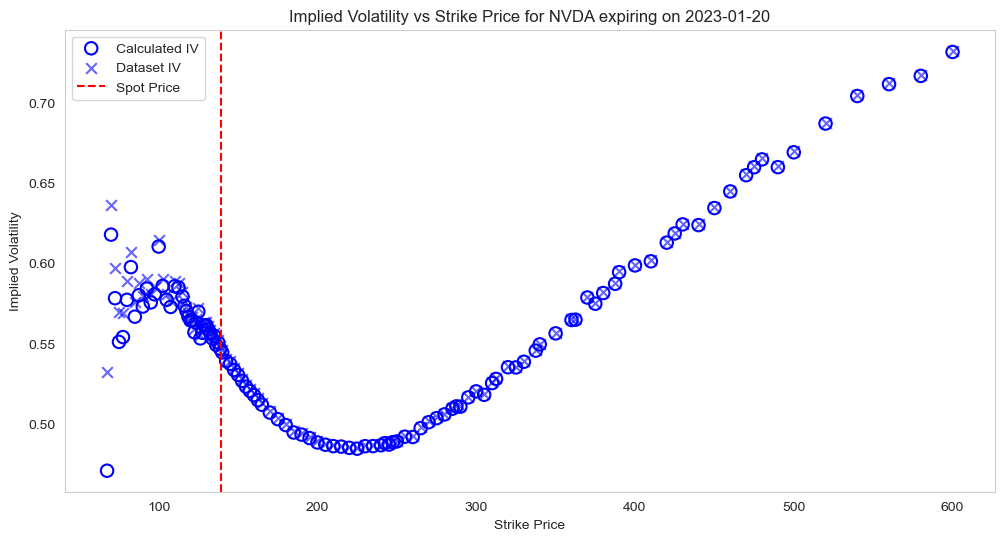

In [10]:
result = plot_iv_vs_strike(ticker='NVDA', exdate_idx=10)

# Implied Volatility Analysis for All Securities

Plotted ticker AMZN, contract length: 106 days, rate: 2.8766%
Plotted ticker MSFT, contract length: 106 days, rate: 2.8766%
Plotted ticker NVDA, contract length: 106 days, rate: 2.8766%
Plotted ticker TSLA, contract length: 106 days, rate: 2.8766%
Plotted ticker META, contract length: 78 days, rate: 2.8766%


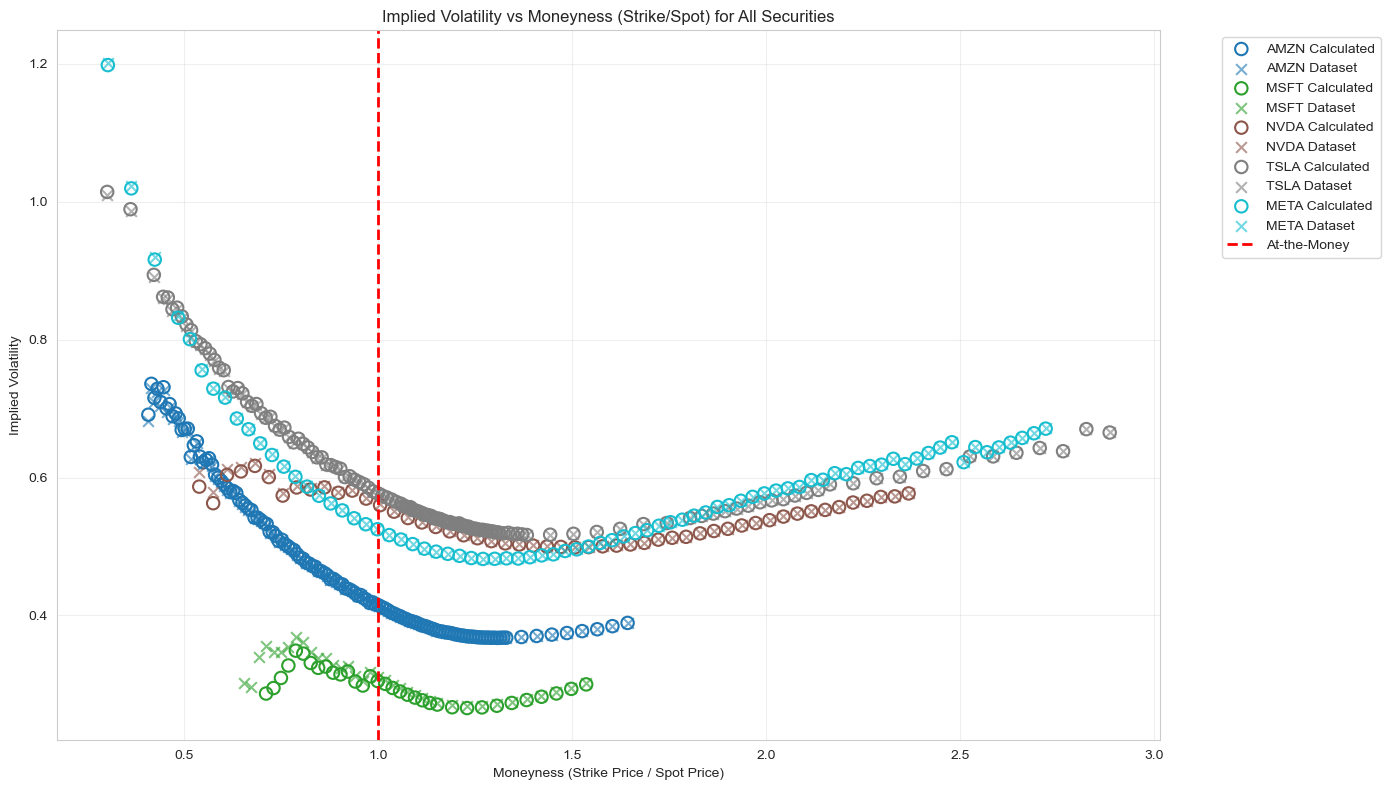

In [11]:
# Loop through all securities and analyze their implied volatilities
# This time, we'll put them all on a single plot with normalized strike prices

all_secids = df_security['secid'].unique()

# Create a single figure for all tickers
plt.figure(figsize=(14, 8))

# Use different colors for different tickers
colors = plt.cm.tab10(np.linspace(0, 1, len(all_secids)))

for idx, secid in enumerate(all_secids):
    df_options_secid = df_options[df_options['secid'] == secid]
    ticker = df_security[df_security['secid'] == secid]['ticker'].values[0]
    
    # Check if this security has option data
    if len(df_options_secid) == 0:
        print(f"No option data for secid {secid}, ticker {ticker}")
        continue
    
    # Select an expiration date (use the 10th one if available, otherwise the middle one)
    unique_exdates = df_options_secid['exdate'].unique()
    if len(unique_exdates) == 0:
        print(f"No expiration dates for secid {secid}, ticker {ticker}")
        continue
    
    exdate_idx = min(10, len(unique_exdates) // 2)
    exdate = unique_exdates[exdate_idx]
    
    contract_length = (pd.to_datetime(exdate) - pd.to_datetime(df_options_secid['date'].min())).days
    t = contract_length / 365  # Time to expiration in years
    
    # Get the risk-free rate
    starting_date = df_options['date'].unique()[0]
    df_rate_start = df_rate[df_rate['date'] == starting_date].copy()
    
    days_diff = np.abs(df_rate_start['days'] - contract_length)
    closest_idx = days_diff.idxmin()
    closest_rate_entry = df_rate_start.loc[closest_idx]
    r = closest_rate_entry['rate'] / 100
    
    # Get spot price
    spot_price = df_security[(df_security['secid'] == secid) & (df_security['date'] == starting_date)]['close'].values[0]
    
    # Extract option entries
    option_entries = df_options_secid[(df_options_secid['exdate'] == exdate) & (df_options_secid['date'] == starting_date)].copy()
    option_entries['strike_price'] = option_entries['strike_price'] / 1000
    
    # Get call entries
    call_entries = option_entries[option_entries['cp_flag'] == 'C'].copy()
    
    if len(call_entries) == 0:
        print(f"No call options for secid {secid}, ticker {ticker}")
        continue
    
    # Calculate implied volatility
    from src.black_scholes import implied_volatility_call
    call_entries['implied_volatility_calculation'] = call_entries.apply(
        lambda row: implied_volatility_call(
            market_price=(row['best_bid'] + row['best_offer']) / 2,
            S0=spot_price,
            K=row['strike_price'],
            t=t,
            r=r)
        , axis=1
    )
    
    # Normalize strike prices by spot price (moneyness)
    call_entries['moneyness'] = call_entries['strike_price'] / spot_price
    
    # Plot calculated IV with hollow circles
    plt.scatter(call_entries['moneyness'], call_entries['implied_volatility_calculation'], 
                marker='o', s=80, facecolors='none', edgecolors=colors[idx], linewidths=1.5,
                label=f'{ticker} Calculated')
    
    # Plot dataset IV with filled squares
    plt.scatter(call_entries['moneyness'], call_entries['impl_volatility'], 
                marker='x', s=60, color=colors[idx], alpha=0.6,
                label=f'{ticker} Dataset')
    
    print(f"Plotted ticker {ticker}, contract length: {contract_length} days, rate: {r*100:.4f}%")

# Add a vertical line at moneyness = 1 (at-the-money)
plt.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='At-the-Money')

plt.title("Implied Volatility vs Moneyness (Strike/Spot) for All Securities")
plt.xlabel("Moneyness (Strike Price / Spot Price)")
plt.ylabel("Implied Volatility")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


We also examine the implied volatility as a function of the time to expiration

Analyzing options for secid: 101310, ticker: AMZN
Target strike price (ATM): 127.82
Found 19 unique expiration dates


Processing expiration dates: 100%|██████████| 19/19 [00:00<00:00, 591.72it/s]


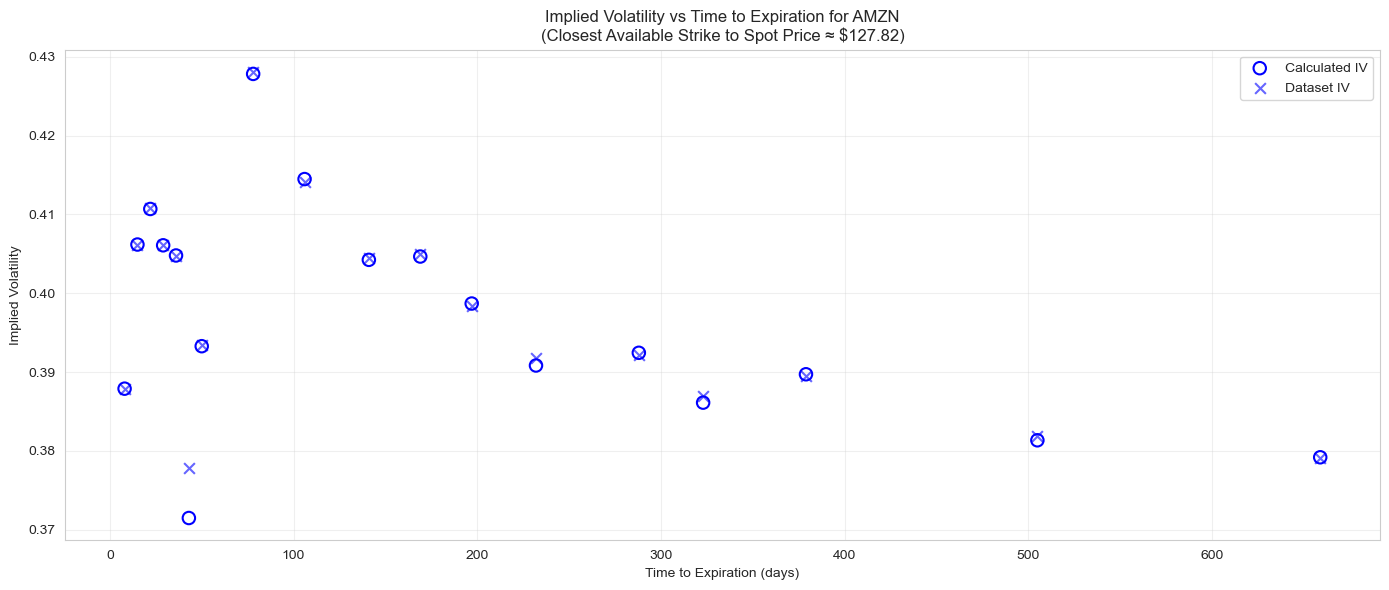


Processed 18 expiration dates
Time to expiry range: 8 to 659 days


In [12]:
# Plot implied volatility as a function of time to expiration for a fixed strike price

# Pick a security id
secid = 101310
df_options_secid = df_options[df_options['secid'] == secid]
ticker = df_security[df_security['secid'] == secid]['ticker'].values[0]
print(f"Analyzing options for secid: {secid}, ticker: {ticker}")

# Select a strike price close to at-the-money
starting_date = df_options['date'].unique()[0]
spot_price = df_security[(df_security['secid'] == secid) & (df_security['date'] == starting_date)]['close'].values[0]
target_strike = spot_price  # At-the-money
print(f"Target strike price (ATM): {target_strike:.2f}")

# Get all unique expiration dates
all_exdates = df_options_secid['exdate'].unique()
print(f"Found {len(all_exdates)} unique expiration dates")

# Prepare data structures for plotting
time_to_expiry_days = []
time_to_expiry_years = []
calculated_ivs = []
dataset_ivs = []
strike_prices_used = []

from src.black_scholes import implied_volatility_call

# Loop through each expiration date
for exdate in tqdm(all_exdates, desc="Processing expiration dates"):
    # Calculate contract length
    contract_length = (pd.to_datetime(exdate) - pd.to_datetime(starting_date)).days
    
    # Skip very short-dated options (less than 7 days)
    if contract_length < 7:
        continue
    
    t = contract_length / 365  # Time to expiration in years
    
    # Get the risk-free rate for this contract length
    df_rate_start = df_rate[df_rate['date'] == starting_date].copy()
    days_diff = np.abs(df_rate_start['days'] - contract_length)
    closest_idx = days_diff.idxmin()
    closest_rate_entry = df_rate_start.loc[closest_idx]
    r = closest_rate_entry['rate'] / 100  # Convert percentage to decimal
    
    # Get options for this expiration date
    option_entries = df_options_secid[(df_options_secid['exdate'] == exdate) & 
                                      (df_options_secid['date'] == starting_date)].copy()
    option_entries['strike_price'] = option_entries['strike_price'] / 1000
    
    # Get call entries
    call_entries = option_entries[option_entries['cp_flag'] == 'C'].copy()
    
    if len(call_entries) == 0:
        continue
    
    # Find the strike price closest to our target strike
    closest_strike_idx = (call_entries['strike_price'] - target_strike).abs().idxmin()
    selected_option = call_entries.loc[closest_strike_idx]
    
    # Calculate implied volatility
    market_price = (selected_option['best_bid'] + selected_option['best_offer']) / 2
    
    # Skip if market price is invalid
    if market_price <= 0 or np.isnan(market_price):
        continue
    
    calculated_iv = implied_volatility_call(
        market_price=market_price,
        S0=spot_price,
        K=selected_option['strike_price'],
        t=t,
        r=r
    )
    
    # Only add if we got a valid implied volatility
    if not np.isnan(calculated_iv):
        time_to_expiry_days.append(contract_length)
        time_to_expiry_years.append(t)
        calculated_ivs.append(calculated_iv)
        dataset_ivs.append(selected_option['impl_volatility'])
        strike_prices_used.append(selected_option['strike_price'])

# Plot the results
plt.figure(figsize=(14, 6))

plt.scatter(time_to_expiry_days, calculated_ivs, 
            marker='o', s=80, facecolors='none', edgecolors='blue', linewidths=1.5,
            label='Calculated IV')

plt.scatter(time_to_expiry_days, dataset_ivs, 
            marker='x', s=60, color='blue', alpha=0.6,
            label='Dataset IV')

plt.xlabel("Time to Expiration (days)")
plt.ylabel("Implied Volatility")
plt.title(f"Implied Volatility vs Time to Expiration for {ticker}\n(Closest Available Strike to Spot Price ≈ ${target_strike:.2f})")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nProcessed {len(time_to_expiry_days)} expiration dates")
print(f"Time to expiry range: {min(time_to_expiry_days)} to {max(time_to_expiry_days)} days")


# Put options

Given the different theoretical basis for american put options, naively plugging the Black-Scholes info would be problematic

In [13]:
from src.binomial_tree import BinomialTreeSimulator
from scipy.optimize import brentq

n_steps = 100


def implied_volatility_put_binomial_tree(market_price, S0, K, t, r, sigma_bounds=(1e-6, 2)):
    """
    Returns the implied volatility of a put option given spot price, strike, time to expiration, 
    and risk-free-interest rate.
    
    Inputs:
    market_price (float): Market price of call option
    S0 (float): Spot price of stock
    K (float): strike price
    t (float): time-to-expiration
    r (float): risk-free-interest rate
    
    Returns:
    Implied volatility (float)
    
    """
    def objective(sigma):
        tree = BinomialTreeSimulator(S0=S0, K=K, T=t, r=r, sigma=sigma, n_steps=n_steps, option_type='put')
        return tree.price_american_option() - market_price

    try:
        # We give this loose bounds to speed things up
        return brentq(objective, *sigma_bounds, xtol = 1e-3, rtol=1e-3)
    except ValueError:
        return np.nan
    

Analyzing options for secid: 143439, ticker: TSLA


/Users/wttai/Documents/Jupyter/quant_fin_project/src/binomial_tree.py:49: RuntimeWarning: overflow encountered in scalar add
  expected_value = (self.p * option_prices[i + 1, j] + (1 - self.p) * option_prices[i + 1, j + 1]) * np.exp(-self.r * self.dt)
/Users/wttai/Documents/Jupyter/quant_fin_project/src/binomial_tree.py:49: RuntimeWarning: overflow encountered in scalar multiply
  expected_value = (self.p * option_prices[i + 1, j] + (1 - self.p) * option_prices[i + 1, j + 1]) * np.exp(-self.r * self.dt)
/Users/wttai/Documents/Jupyter/quant_fin_project/src/binomial_tree.py:49: RuntimeWarning: invalid value encountered in scalar add
  expected_value = (self.p * option_prices[i + 1, j] + (1 - self.p) * option_prices[i + 1, j + 1]) * np.exp(-self.r * self.dt)
/Users/wttai/Documents/Jupyter/quant_fin_project/src/binomial_tree.py:49: RuntimeWarning: invalid value encountered in scalar add
  expected_value = (self.p * option_prices[i + 1, j] + (1 - self.p) * option_prices[i + 1, j + 1]) * np.

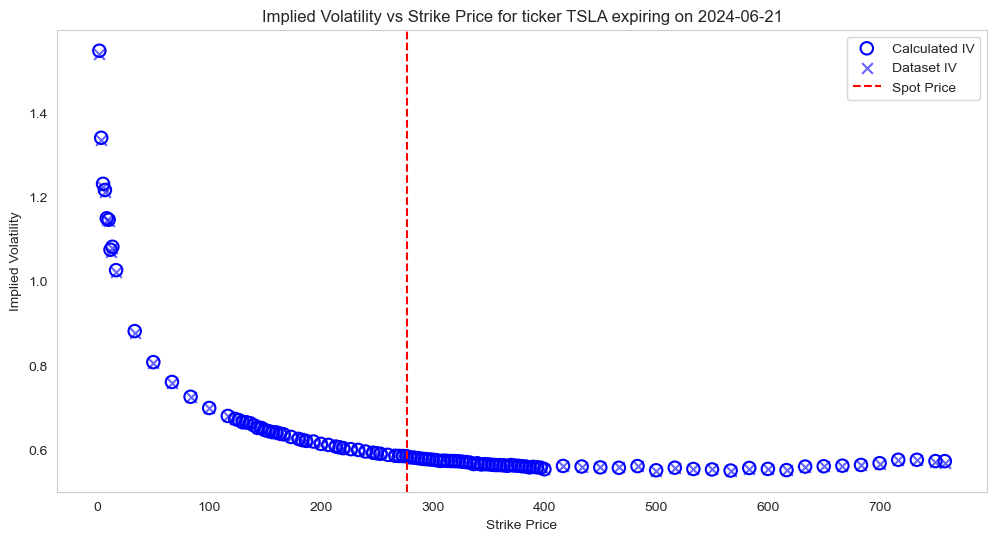

In [35]:
# Extract the data for the choosen contract length

# Pick a security id
ticker = "TSLA"
#secid = 101310
df_options_secid = df_options[df_options['ticker'] == ticker]
secid = df_security[df_security['ticker'] == ticker]['secid'].values[0]
print(f"Analyzing options for secid: {secid}, ticker: {ticker}")

spot_price = df_security[(df_security['ticker'] == ticker) & (df_security['date'] == starting_date)]['close'].values[0]

option_entries = df_options_secid[(df_options_secid['exdate'] == exdate) & (df_options_secid['date'] == starting_date)].copy()
option_entries['strike_price'] = option_entries['strike_price'] / 1000  # The strike prices are given in units of 1000 * actual strike price

# examine the put entries
put_entries = option_entries[option_entries['cp_flag'] == 'P'].copy()



# calculate the implied volatility for each put option entry
put_entries['implied_volatility_calculation'] = put_entries.apply(
    lambda row: implied_volatility_put_binomial_tree(
        market_price=(row['best_bid'] + row['best_offer']) / 2,
        S0=spot_price,
        K=row['strike_price'],
        t=t,
        r=r)
    , axis=1
)

# Plot the implied volatility vs strike price
plt.scatter(put_entries['strike_price'], put_entries['implied_volatility_calculation'], 
            marker='o', s=80, facecolors='none', edgecolors='blue', linewidths=1.5,
            label='Calculated IV')

# The data also comes with implied volatility directly
plt.scatter(put_entries['strike_price'], put_entries['impl_volatility'], 
            marker='x', s=60, color='blue', alpha=0.6,
            label='Dataset IV')

# Add a vertical line at the spot price
plt.axvline(x=spot_price, color='red', linestyle='--', label='Spot Price')
plt.title(f"Implied Volatility vs Strike Price for ticker {ticker} expiring on {exdate}")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.legend()
plt.grid()
plt.show()


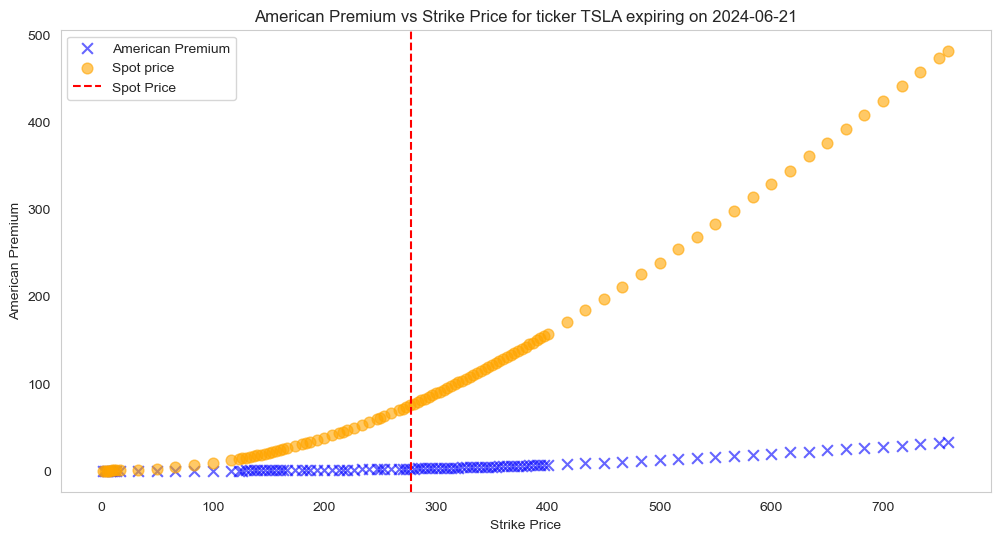

In [36]:
# We estimate the american premium using the above calculation on implied volatility

def american_premium(S0, K, t, r, sigma):
    """
    Returns the implied volatility of a put option given spot price, strike, time to expiration, 
    and risk-free-interest rate.
    
    Inputs:
    market_price (float): Market price of call option
    S0 (float): Spot price of stock
    K (float): strike price
    t (float): time-to-expiration
    r (float): risk-free-interest rate
    
    Returns:
    Implied volatility (float)
    
    """
    tree = BinomialTreeSimulator(S0=S0, K=K, T=t, r=r, sigma=sigma, n_steps=n_steps, option_type='put')
    return tree.american_premium()
    
put_entries['american_premium'] = put_entries.apply(
    lambda row: american_premium(
        S0=spot_price,
        K=row['strike_price'],
        t=t,
        r=r,
        sigma=row['implied_volatility_calculation'])
    , axis=1
)

# The data also comes with implied volatility directly
plt.scatter(put_entries['strike_price'], put_entries['american_premium'], 
            marker='x', s=60, color='blue', alpha=0.6,
            label='American Premium')

plt.scatter(put_entries['strike_price'], 0.5 * (put_entries['best_bid'] + put_entries['best_offer']), 
            marker='o', s=60, color='orange', alpha=0.6,
            label='Spot price')

# Add a vertical line at the spot price
plt.axvline(x=spot_price, color='red', linestyle='--', label='Spot Price')
plt.title(f"American Premium vs Strike Price for ticker {ticker} expiring on {exdate}")
plt.xlabel("Strike Price")
plt.ylabel("American Premium")
plt.legend()
plt.grid()
plt.show()


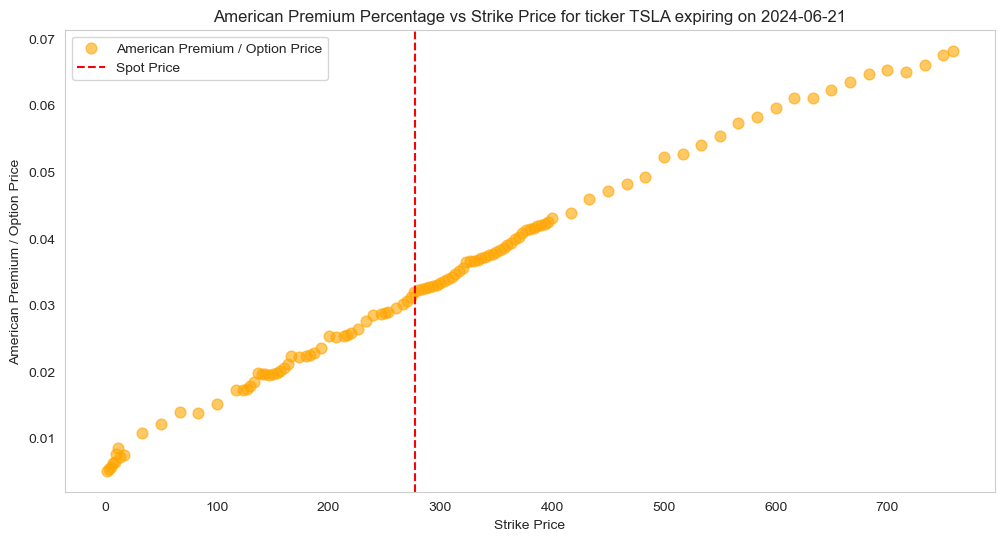

In [42]:
# Plot the premium as a percentage of the option price
plt.scatter(put_entries['strike_price'], put_entries['american_premium'] / (0.5 * (put_entries['best_bid'] + put_entries['best_offer'])), 
            marker='o', s=60, color='orange', alpha=0.6,
            label='American Premium / Option Price')

# Add a vertical line at the spot price
plt.axvline(x=spot_price, color='red', linestyle='--', label='Spot Price')
plt.title(f"American Premium Percentage vs Strike Price for ticker {ticker} expiring on {exdate}")
plt.xlabel("Strike Price")
plt.ylabel("American Premium / Option Price")
plt.legend()
plt.grid()
plt.show()

In [37]:
put_entries[['strike_price', 'american_premium', 'best_bid']]

strike_price  american_premium  best_bid
38471         10.00          0.002251      0.15
38472        100.00          0.133503      8.55
38473        116.67          0.209638     11.50
38474         11.67          0.002297      0.02
38475        123.33          0.235972     13.35
...             ...               ...       ...
38575        733.33         30.183634    453.20
38576        750.00         32.017750    470.90
38577        758.33         32.843717    478.95
38578          8.33          0.001242      0.00
38579         83.33          0.083814      5.80

[109 rows x 3 columns]